In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/cs236g/cs273b-main

/content/drive/My Drive/cs236g/cs273b-main


In [ ]:
import data_loader
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import tensorflow as tf
import math
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import sys
import updated_plots
%matplotlib inline
import tensorflow.python.keras.backend as K
import plotly.express as px
from sklearn.metrics import pairwise_distances

In [ ]:
torch.cuda.is_available()

True

In [ ]:
ALPHABET = 'GALMFWKQESPVICYHRNDT'

In [ ]:
def onehot_encode(aaseq: str):
    """
    Convert AA sequence to onehot encoding numpy array.
    Args:
        aaseq - str
    Returns:
        onehotarr - (lenseq, 20) np.array
    """
    alphabet = 'GALMFWKQESPVICYHRNDT'
    aa2int = {k: i for i,k in enumerate(alphabet)}
    #int2aa = {i: k for i,k in enumerate(alphabet)}

    lenseq = len(aaseq)
    onehotarr = np.zeros((lenseq, 20), dtype=int)
    for i,aa in enumerate(aaseq):
        onehotarr[i, aa2int[aa]] = 1

    return onehotarr

In [ ]:
def translate(seq):
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
        'NNG':'C'
    } 
    protein ="" 
    if len(seq)%3 == 0: 
        for i in range(0, len(seq), 3): 
            codon = seq[i:i + 3]
            aa = table[codon]
            if aa == '_':
                break
            protein+= table[codon] 
    return protein

In [ ]:
oh = lambda x: onehot_encode(x["Extended Domain sequence"])

nucrepr_data = pd.read_csv("./data/NucRepr_data.csv")
nucrepr_data["one_hot_encoding"] = nucrepr_data["Extended Domain sequence"].apply(onehot_encode)


# Each sample should have an 80 AA sequence; let's make sure that's the case
act = np.sum(nucrepr_data["one_hot_encoding"].apply(np.sum))
exp = len(nucrepr_data["one_hot_encoding"])*80
print("Expected:", exp)
print("Actual:", act)

Expected: 429520
Actual: 429519


In [ ]:
loader = data_loader.DataLoader("./data/UniRep1900_BareNucRepr.csv")
id_train, id_val, id_test = loader.getIdx()

n_train_repr = len(id_train)
n_val_repr = len(id_val)
n_test_repr = len(id_test)
n_seq = 80
n_AA = 20

_, (y_train_repr, y_val_repr, y_test_repr) = loader.loadTrainValTest()

nuc_csv = pd.read_csv("./data/UniRep1900_BareNucRepr.csv")
nuc_csv["one_hot_encoding"] = nuc_csv["Extended Domain sequence"].apply(onehot_encode)

x_train_repr = np.zeros((n_train_repr, 1, n_seq, n_AA))
for i in range(n_train_repr):
    x_train_repr[i,0,:,:] = nuc_csv.loc[id_train[i],"one_hot_encoding"]
    
x_val_repr = np.zeros((n_val_repr, 1, n_seq, n_AA))
for i in range(n_val_repr):
    x_val_repr[i,0,:,:] = nuc_csv.loc[id_val[i],"one_hot_encoding"]

x_test_repr = np.zeros((n_test_repr, 1, n_seq, n_AA))
for i in range(n_test_repr):
    x_test_repr[i,0,:,:] = nuc_csv.loc[id_test[i],"one_hot_encoding"]

x_repr = np.concatenate([x_train_repr, x_val_repr, x_test_repr], axis = 0)
y_repr = np.concatenate([y_train_repr, y_val_repr, y_test_repr], axis = 0)

print(x_train_repr.shape)
print(x_val_repr.shape)
print(x_test_repr.shape)
print(x_repr.shape)
print(y_repr.shape)

(2792, 1, 80, 20)
(262, 1, 80, 20)
(239, 1, 80, 20)
(3293, 1, 80, 20)
(3293,)


In [ ]:
repr_cutoff = 4.85 # Define 4.85 as the cutoff for what is considered as repressive
noise_level = 1
real_repr = torch.Tensor(x_repr[y_repr>repr_cutoff,:,:,:])
dims = real_repr.size()
real_repr = real_repr + torch.randn(dims)*noise_level
real_repr = F.softmax(real_repr, dim = 3)
print(dims)

torch.Size([256, 1, 80, 20])


# 2. W-GAN

### Generator *(Source: Coursera)*

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=(8,4), stride=(4,2)),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=(6,3), stride=2),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=(10,4), stride=(2,1), final_layer=False),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Softmax(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        fakes = self.gen(x)

        return F.gumbel_softmax(fakes, tau=1, hard=False, dim=-1)
        #return F.threshold( torch.add(torch.sub( fakes, F.max_pool2d(fakes, kernel_size=(1,20)) ),1) ,1-1e-6,0)

def get_noise(n_samples, z_dim, device='gpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### Critic *(Source: Coursera)*

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim, kernel_size=(40,20), stride=1),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=(10,1), stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

###  Gradient Penalty & Loss *(Source: Coursera)*

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - torch.ones_like(gradient_norm))**2)
    #### END CODE HERE ####
    return penalty

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = -torch.mean(crit_real_pred - crit_fake_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_avg = torch.mean(image_unflat, 0)
    plt.imshow(image_avg.permute(1, 2, 0).squeeze())
    plt.show()

## Training *(Source: Coursera)*

In [ ]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

dataloader = DataLoader(
    real_repr,
    batch_size=batch_size,
    shuffle=True)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.kaiming_normal_(m.weight)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

Step 50: Generator loss: 0.0063467664923518895, critic loss: 0.026292603483423594


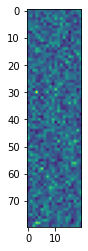

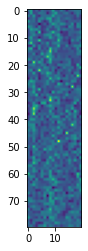

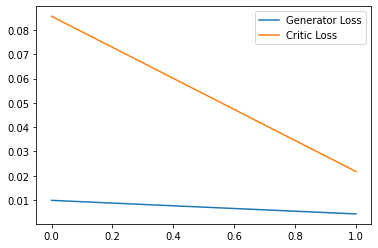

Step 100: Generator loss: 0.0027410023484844715, critic loss: 0.0006439716145396233


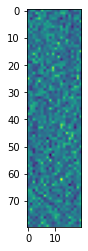

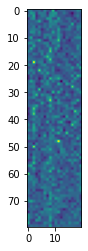

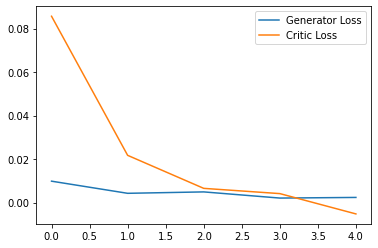

Step 150: Generator loss: 0.007097457470372319, critic loss: -0.01451651392504573


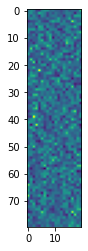

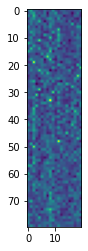

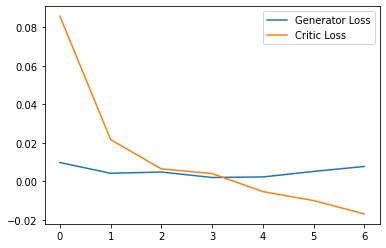

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        real = real.float()

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real.float())

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

# 2. Classifier

In [ ]:
model_type = 'CNN'
dataOrder = ['comb', 'repr', 'tiling']
input_shape = (1, 80, 20)


settings = {'NumConvLayer': 2, 'NumFilter': (40, 24), 'DropOut': 0.4, 'Patience': 2}
input_shape = (1, 80, 20)

initializer = tf.initializers.VarianceScaling(scale=2.0)
layers = [
    tf.keras.layers.Conv2D(settings['NumFilter'][0], (1,40), activation='relu', padding = 'same',
                                kernel_initializer=initializer, input_shape = input_shape),
    tf.keras.layers.Conv2D(settings['NumFilter'][1], (1,40), activation='relu', padding = 'same',
                                kernel_initializer=initializer, input_shape = input_shape),
    tf.keras.layers.Dropout(settings['DropOut']),
    tf.keras.layers.MaxPool2D(pool_size = (1,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_initializer=initializer),
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_mean_squared_error', min_delta=0.0001, patience=settings['Patience'])

model = tf.keras.Sequential(layers)
print(model.summary())

n_epochs = 50
val_losses = []
learning_rates = [5e-4]
for lr in learning_rates:
    print(lr)
    out, val_mse = modelTrain(model, lr, n_epochs, batch_size=128, data = dataOrder[0], 
                              earlystop_callback = [earlystop_callback])
    
    plot(out, data = dataOrder[0], model_type=model_type)
    plotPred(model, data = dataOrder[0], model_type=model_type)
    plotPred(model, data = dataOrder[1], model_type=model_type)
    plotPred(model, data = dataOrder[2], model_type=model_type)
    
    print(model.predict(x_train_til))
    
    print('Validation MSE (Repressor Data):', model.evaluate(x_val_repr, y_val_repr))
    print('Validation MSE (Tiling Data):', model.evaluate(x_val_til, y_val_til))